# **Walmart Sales Projections**
### The Development of a ML Model to Predict Future Sales Using Existing Data
Dataset: Walmart Sales\
Publisher: MIKHAIL\
URL: https://www.kaggle.com/datasets/mikhail1681/walmart-sales?resource=download\
\
Analysis and Visualizations by: **Jacob Krol**
___

### **Project Scope:**
The goal of this project is to use the dataset, containing a number of variables which may or may not contribute to Walmart's sales figures, in order to predict the future sales which can be expected by the company under given circumstances.\
 \
 Ideally, this model will help to understand the sales trend in such a way that would allow for business initiatives to be taken which can increase overall sales.\
 \
The analysis will take a step-wise approach in order to demonstrate the thought process being used to approach this problem. The PACE (Plan - Analyze - Construct - Execute) strategy will be used to break the project down further. Substeps between each of the main steps will be presented as well in order to attempt to present the workflow in a linear manner. However, it should be noted that the process of data analysis is largely cyclical, involving many itterations between different steps and evolutions of the project. A simplified linear workflow like this is not entirely reflective of the data analysis workflow.

___


 



 ##### **Step 1: Plan**
 During this stage of the process, I am mostly concerned with forming a generalized approach to the dataset. Generally, the pure planning stage consists of collaboration between cross-functional teams and is great for establishing the scope and KPIs of a project. This project's scope has been defined above.\
 \
 The primary questions which I am concerned with at this stage are:
 1. What is the scope of the project?
 2. What are the key deliverables which are expected to be delivered for this project?
 3. Who are the key stakeholders in this project?
 4. What is the timeline for the project?
 5. How was the data collected? 
 6. Is this data reliable?
 7. Are there ethical concerns associated with the use of or contents of the data set?
 8. What python packages will be needed for this analysis?
 9. What models may be useful for this project?


Again, as this is an analysis for the sake of demonstration with a public dataset, many of the above questions are not relevent. It is going to be assumed that the data is accurate for this practice. However, ethical considerations should still always be taken. In this case, there is no data or variables present which I believe to be unethical. With regards to which model may be useful, I am immediately draw to the Poisson regression model, since this is what would generally be used for forcasing sales data. That being said, I will not rule out the Random Forest approach, which could offer a less transparent but higher-scoring model overall.

___

 ##### **Step 1.5: Plan/ Analyze**
 During this stage in the process, it is important to become familiar with the dataset. This is largely where the technical planning begins. Once I have a better idea of the contents of the dataset, I can begin forming basic visualizations which will then inform which variables are focused on, which data engineering methods will be used to generate additional useful derived data, and which modeling methods will be the most useful.
  
 The primary questions which I am concerned with at this stage are:
 1. What variables are included in the dataset?
 2. How many variables are in the dataset?
 3. How many entries are in the dataset?
 4. Are there any null values or outliers present in the dataset?
 5. Is there any apparent trend which is contributing to the outliers or null values which will affect how they are handled?
6. Does an initial analysis uncover any multicollinearity which needs to be considered?

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, DMatrix, plot_importance
import pickle

# Silence warnings from seaborn
import warnings
warnings.filterwarnings("ignore")

In [147]:
# Importing the dataset and make a copy of it to avoid any changes in the original dataset
df0 = pd.read_csv('walmart_sales.csv')
df = df0.copy()

# Display the first 10 rows of the dataset
df.head(10)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,2010-03-19,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,2010-03-26,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,2010-04-02,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,2010-04-09,1545418.53,0,65.86,2.770,210.622857,7.808


In [148]:
# Check for null values and look at the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [149]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'],  format='mixed')

In [150]:
# Ensure that Holiday_Flag only contains 0 and 1
df['Holiday_Flag'].unique()

array([0, 1], dtype=int64)

In [151]:
# Look at the indicator values of the dataset to get an idea of its distribution
df.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


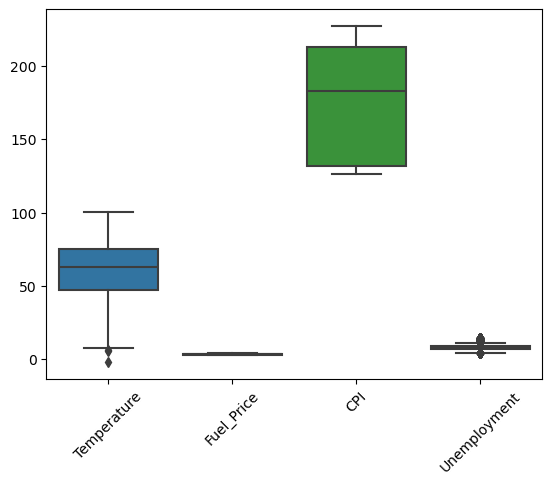

In [152]:
# Use a boxplot to visualize the distribution of the continuous variables, but leave out the weekly sales column, as it is the target variable, 
# and is on a very different scale compared to the other variables.
sns.boxplot(data=df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
plt.xticks(rotation=45)
plt.show()

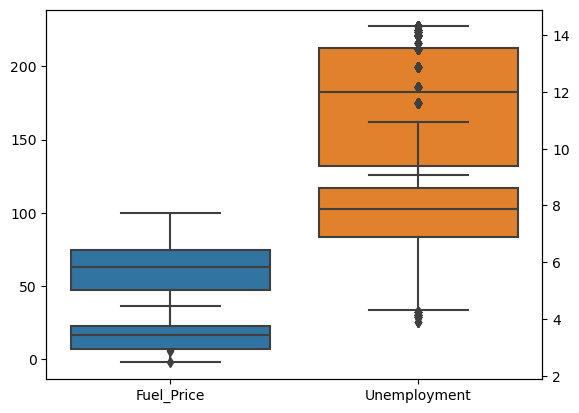

In [153]:
# Let's separate the fuel price and unemployment rate into a separate y-axis to better visualize the data
fig, ax = plt.subplots()
sns.boxplot(data=df[['Temperature', 'CPI']], ax=ax)
ax2 = ax.twinx()
sns.boxplot(data=df[['Fuel_Price', 'Unemployment']], ax=ax2)
plt.show()

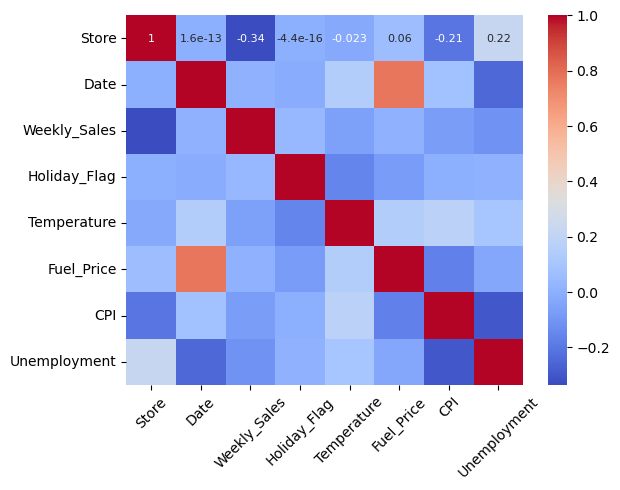

In [154]:
# We can look for multicollinearity by calculating the correlation matrix and plotting it using a heatmap.
# This will help us to chose the most important features for our model.
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={'fontsize': 8})
plt.xticks(rotation=45)
plt.show()

 ##### **Step 1.5: Plan/ Analyze Summary**
 - Observations: 
    - The dataset is *small* with only about 6,300 entries. This will limit what kinds of models can be used.
    - There are no null values within the dataset
    - The datetime was formatted as a string, which was promptly changed to a datetime in order to avoid issues later on.
    -  There appear to be outliers in the Temperature and Unemployment columns. These were easily identified using box plots and the describe() function.
    - Date and Fuel_Price share are multicollinear values. For the sake of being highly scruttenous, a cutoff of a correlation of 0.75 will be used. Therefore, only one of these parameters will be used in the final dataset. Fuel_Price has a stronger relationship to the target variable out of the two.
    - Fuel_Price, Unemployment, and Store have the largest correlation to the target variable.  

 - Next Steps:
    - Outliers will be investigated and managed.
    -  The following columns will be added to investigate if these derived variable are better indicators than the primary variables are.
       - Unemployment/ Fuel_Price
       - Unemployment/ CPI
       - Fuel_Price/ CPI
       - Month
       - Quarter of month (Do people purchase more in the begging on the month, middle, or end?)
          - Month_Q1
          - Month_Q2
          - Month_Q3
          - Month_Q4
    - A new correlation matrix will be made to investigate the modified values.
___

 ##### **Step 2: Analyze**
During this stage of the analysis, the main focus is to make any necessary changes to the dataset which will allow for a more robust and/or accurate analysis. For this analysis, this includes:
1. Investigating and managing any outliers.
2. Creating any derived variables which were identified as potentially useful during the Plan/ Analyze or Plan stages. 

Additionally, the dataset will need re-interrogation now that it has been modified. The same methods can be used from the Plan/ Analyze stage in order to do this.

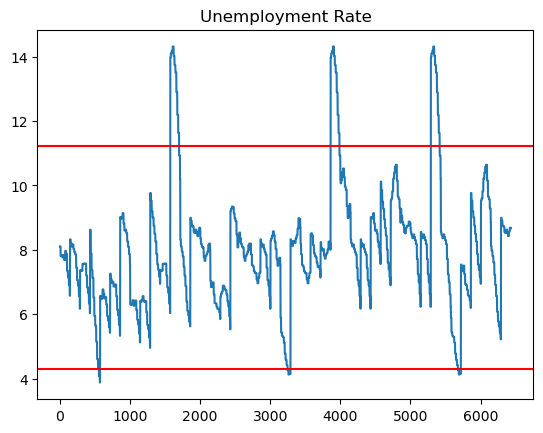

In [155]:
# Look more closely at the datasets with outliers to determine how to handle them

# We'll start with a line graph of unemployment. If we find that the outliers 
# appear to fit with the overall trend, we can leave them in the dataset.

# Plot the unemployment rate as a line graph against the date
plt.plot(df['Unemployment'])
plt.title('Unemployment Rate')
# Add a horizontal line at the 25% and 75% quartiles +/- 1.5 times the IQR
plt.axhline(df['Unemployment'].quantile(0.25) - 1.5*(df['Unemployment'].quantile(0.75) - df['Unemployment'].quantile(0.25)), color='r')
plt.axhline(df['Unemployment'].quantile(0.75) + 1.5*(df['Unemployment'].quantile(0.75) - df['Unemployment'].quantile(0.25)), color='r')
plt.show()

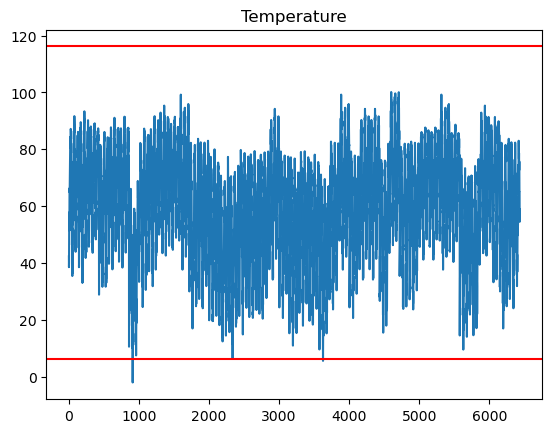

In [156]:
# Now let's look at the temperature data in the same way
plt.plot(df['Temperature'])
plt.title('Temperature')
# Add a horizontal line at the 25% and 75% quartiles +/- 1.5 times the IQR
plt.axhline(df['Temperature'].quantile(0.25) - 1.5*(df['Temperature'].quantile(0.75) - df['Temperature'].quantile(0.25)), color='r')
plt.axhline(df['Temperature'].quantile(0.75) + 1.5*(df['Temperature'].quantile(0.75) - df['Temperature'].quantile(0.25)), color='r')
plt.show()

In [157]:
# The outliers appear to be abnomal peaks in the data, 
#so we'll adjust their values to the 95th percentile to preserve their 
#impact on the model without skewing the data too much.
df['Temperature'] = np.where(df['Temperature'] > df['Temperature'].quantile(0.95), df['Temperature'].quantile(0.95), df['Temperature'])
df['Unemployment'] = np.where(df['Unemployment'] > df['Unemployment'].quantile(0.95), df['Unemployment'].quantile(0.95), df['Unemployment'])

In [158]:
# Repeat this for the lower outliers using the 5th percentile
df['Temperature'] = np.where(df['Temperature'] < df['Temperature'].quantile(0.05), df['Temperature'].quantile(0.05), df['Temperature'])
df['Unemployment'] = np.where(df['Unemployment'] < df['Unemployment'].quantile(0.05), df['Unemployment'].quantile(0.05), df['Unemployment'])

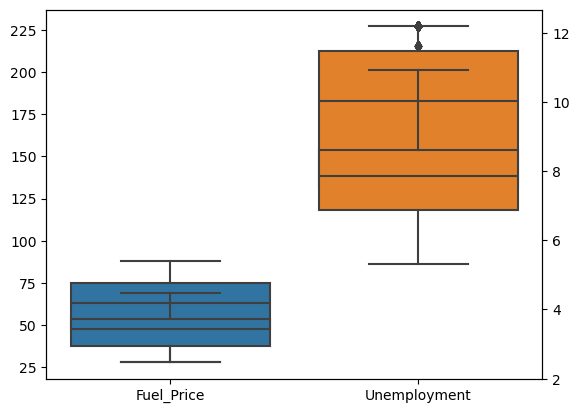

In [159]:
# Visualize the data after removing the outliers with boxplots
fig, ax = plt.subplots()
sns.boxplot(data=df[['Temperature', 'CPI']], ax=ax)
ax2 = ax.twinx()
sns.boxplot(data=df[['Fuel_Price', 'Unemployment']], ax=ax2)
plt.show()

In [160]:
# Note the tighter spread of data. The remianing outliers will be left in
# for now. They may be removed later if they are found to be skewing the model.

In [161]:
# Add the previously defined columns to the dataset
df['Unemployment_per_Fuel_Price'] = df['Unemployment'] / df['Fuel_Price']
df['Unemployment_per_CPI'] = df['Unemployment'] / df['CPI']
df['Fuel_Price_per_CPI'] = df['Fuel_Price'] / df['CPI']
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day
df['Month_Q1'] = df['Day'].apply(lambda x: 1 if x <= 7 else 0)
df['Month_Q2'] = df['Day'].apply(lambda x: 1 if 7 < x <= 14 else 0)
df['Month_Q3'] = df['Day'].apply(lambda x: 1 if 14 < x <= 21 else 0)
df['Month_Q4'] = df['Day'].apply(lambda x: 1 if 21 < x else 0)
df.drop('Day', axis=1, inplace=True)

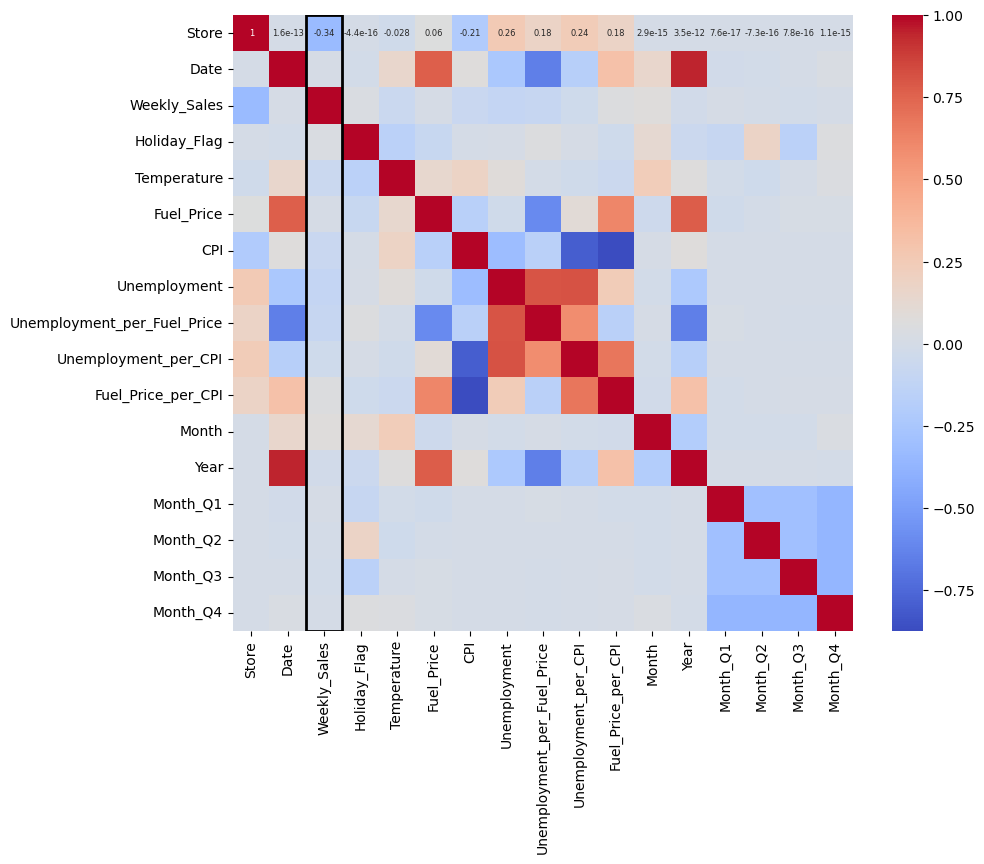

In [203]:
# Let's look at the correlation matrix again 
# to see if the new columns have any impact
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', annot_kws={'fontsize': 6})
plt.xticks(rotation=90)
ax = plt.gca()
ax.add_patch(plt.Rectangle((2, 0), 1, len(corr), fill=False, edgecolor='black', lw=2))
plt.show()

 ##### **Step 2: Analyze Summary**
  - Observations: 
    -  All added columns regarding unemployment and CPI demonstrate strong multicollinearity, with no added correlative strength to the target variable than the variables from which they were derived. Therefore, those collumns will not be used to build the model.
    - The year column generated the expected multicollinearity with Fuel_Price. It will not be used for the model.
    - The columns regarding the quarter of the month appear to have a moderate impact on Weekly_Sales, showing a higher correlation at the middle and end of the month, when people frequently get paid.
    - The Month itself also appears to have a moderate correlation with the target variable with no strong multicollinearities! Nice! 

 - Next Steps:
    - Pick the variables which will go in to the model
    - Split the data into training, validation, and test data.
    - Build model candidates.
    - Evaluate the performance of the model candidates with validation data.
    - Select the highest scoreing candidate as the model which will be further worked with.
    
___

 ##### **Step 2.5: Analyze/ Construct**
 During this stage of the process, I am focused on how the best model can be made for predicting the sales data. Now that I believe I have established the variables which will be used in the model, I will split the data into training, validation, and testing data before building the models from the training data, validating them against the validation data, and comparing their scores to one another. The best performing model will be the one which progresses, and is used for the final model construction and evalution of data. The primary goal of this stage is simply utilizing the data which has been curated to build the best possible model. If none are sufficient, a return to previous steps will be required.


In [163]:
# train test split
X = df.drop(['Date', 'Year', 'Weekly_Sales', 'Unemployment_per_CPI', 'Fuel_Price_per_CPI','Unemployment_per_Fuel_Price'], axis=1)
y = df['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [164]:
# check the shape of the datasets
for dataset in [X_train, X_val, X_test, y_train, y_val, y_test]:
    print(dataset.shape)

(4504, 11)
(965, 11)
(966, 11)
(4504,)
(965,)
(966,)


___
### Linear Regression

In [165]:
# Fit the data to the Poisson regression model
lin = LinearRegression()
lin.fit(X_train, y_train)

LinearRegression()

In [166]:
# Predict the values of the validation set
y_pred = lin.predict(X_val)
# Calculate the mean squared error
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate the R2 score
r2 = r2_score(y_val, y_pred)
print(f'R2 Score: {r2}')

results = pd.DataFrame(
    {
        'Model': ['Linear Regression'],
        'Mean Squared Error': [mse],
        'R-Squared': [r2]
    }
)

Mean Squared Error: 264394208646.42126
R2 Score: 0.14589311956155537


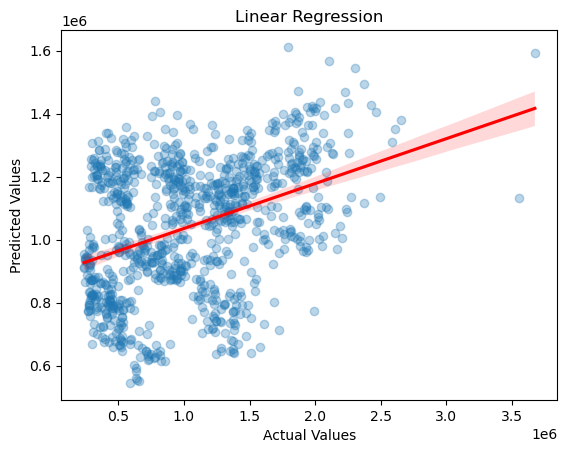

In [167]:
sns.regplot(x=y_val, y=lin.predict(X_val), line_kws={'color':'red'}, scatter_kws={'color':'#1f77b4','alpha':0.3})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression')
plt.show()

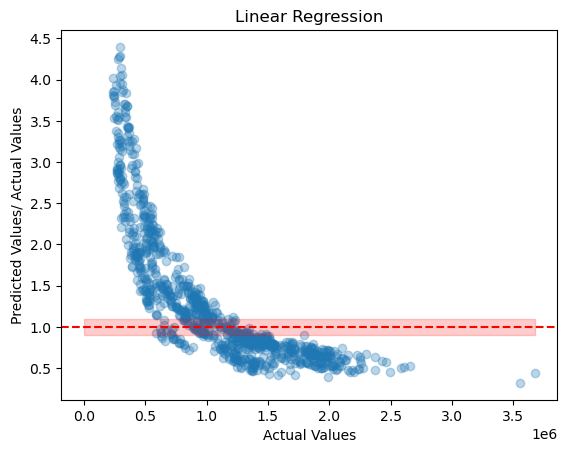

In [168]:
# Plot the predicted values against the actual values
plt.scatter(x= y_val, y= y_pred/y_val, alpha=0.3)
# Add a highlight box at y=0.9 to y=1.1 to show the range of values
plt.gca().add_patch(plt.Rectangle((0.9, 0.9), y_val.max(), 0.2, fill=True, color= 'red', alpha=0.2))
plt.axhline(1, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values/ Actual Values')
plt.title('Linear Regression')
plt.show()

Ideally, this would result in a distribution around y = 1, indicating that the forcasted sales are largely similar to the projected sales.\
\
Let's try utilizing Gradient Bossting to land on something a little bit better. 

___

### XGBoost with GridSearch

In [169]:
# Use the data to set up a gradient boosting regressor model
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    device='cuda'
    )

cv_params = {
    'device': ['cuda'],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
}

xgb_cv = GridSearchCV(xgb, cv_params, cv=5, refit=True)

In [170]:
%%time
if os.path.exists('models/basereg_model.pkl'):
    with open('models/basereg_model.pkl', 'rb') as f:
        xgb_cv = pickle.load(f)
        print('Model loaded from disk')
    
else:
    xgb_cv.fit(X_train, y_train)
    # Save the model to disk
    pickle.dump(xgb_cv, open('models/basereg_model.pkl', 'wb'))

Model loaded from disk
CPU times: total: 0 ns
Wall time: 13.5 ms


In [171]:
def generate_results(model_name:str, model_object):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object

    Returns a pandas df with the R-squared and mean squared error as scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    mean_sq_error = mean_squared_error(y_val, model_object.predict(X_val))
    r2 = r2_score(y_val, model_object.predict(X_val))

    output = pd.DataFrame({'Model': [model_name],
                            'Mean Squared Error': [mean_sq_error],
                            'R-Squared': [r2]
                              })
    return output


In [172]:
xgb_cv.best_params_

{'device': 'cuda',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 300}

In [173]:
tmp = generate_results('XGB_MSE_0', xgb_cv)
results = pd.concat([results, tmp], axis=0)
results

,Model,Mean Squared Error,R-Squared
0,Linear Regression,2.643942e+11,0.145893
0,XGB_MSE_0,7.129052e+09,0.976970


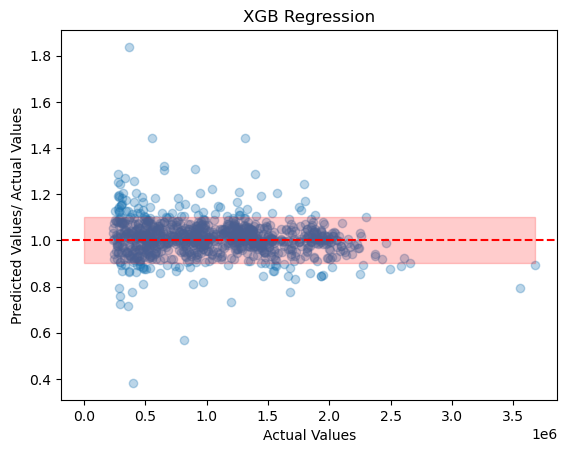

In [174]:
# Graph the data like before
plt.scatter(x= y_val, y= xgb_cv.predict(X_val)/y_val, alpha=0.3)
plt.gca().add_patch(plt.Rectangle((0.9, 0.9), y_val.max(), 0.2, fill=True, color= 'red', alpha=0.2))
plt.axhline(1, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values/ Actual Values')
plt.title('XGB Regression')
plt.show()

This is MUCH better, but we're still not there. Especially since the band around the data is a 10% margin of error! This can be improved quite a bit.
___

### Random Forest with GridSearch

In [175]:
# Use the data to set up a random forest regressor model
rf = RandomForestRegressor(random_state=42)

cv_params = {
    'max_depth': [3, 5, 7],
    'max_features': [1.0],
    'max_samples': [1.0],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300],
}

rf_cv = GridSearchCV(rf, cv_params, cv=5, refit=True)

In [176]:
%%time
if os.path.exists('models/rf_model.pkl'):
    rf_cv = pickle.load(open('models/rf_model.pkl', 'rb'))
    print('Model loaded from disk')
else:
    rf_cv.fit(X_train, y_train)
    # Save the model to disk
    pickle.dump(xgb_cv, open('models/rf_model.pkl', 'wb'))

Model loaded from disk
CPU times: total: 0 ns
Wall time: 13 ms


In [177]:
rf_cv.best_params_

{'device': 'cuda',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 300}

In [178]:
tmp = generate_results('RF_MSE_0', rf_cv)
results = pd.concat([results, tmp], axis=0)
results

,Model,Mean Squared Error,R-Squared
0,Linear Regression,2.643942e+11,0.145893
0,XGB_MSE_0,7.129052e+09,0.976970
0,RF_MSE_0,7.129052e+09,0.976970


In [179]:
# results = results.iloc[:2]

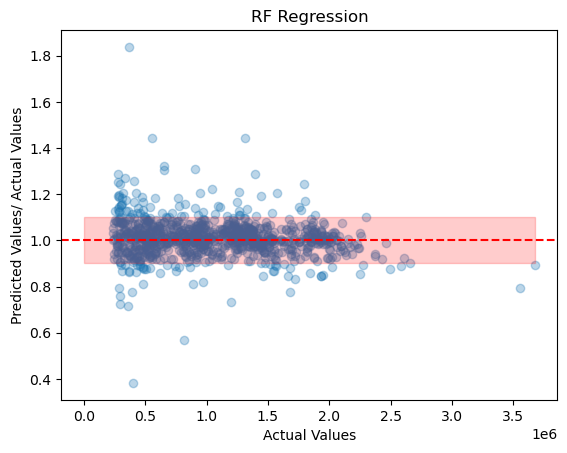

In [180]:
# Graph the data like before
plt.scatter(x= y_val, y= rf_cv.predict(X_val)/y_val, alpha=0.3)
plt.gca().add_patch(plt.Rectangle((0.9, 0.9), y_val.max(), 0.2, fill=True, color= 'red', alpha=0.2))
plt.axhline(1, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values/ Actual Values')
plt.title('RF Regression')
plt.show()

___

### Fine Tuning XGBoost with Grid Search Using Different Objectives

In [181]:
# Use the data to set up a gradient boosting regressor model
xgb = XGBRegressor(
    objective='reg:quantileerror', # We'll try a different objective function
    random_state=42,
    quantile_alpha=0.9,
    # device='cuda'
)

cv_params = {
    # 'device': ['cuda'],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
}

xgb_cv = GridSearchCV(xgb, cv_params, cv=5, refit=True)

In [182]:
%%time
if os.path.exists('models/quantile_model.pkl'):
    xgb_cv = pickle.load(open('models/quantile_model.pkl', 'rb'))
    print('Model loaded from disk')
else:
    xgb_cv.fit(X_train, y_train)
    # Save the model to disk
    pickle.dump(xgb_cv, open('models/quantile_model.pkl', 'wb'))

Model loaded from disk
CPU times: total: 15.6 ms
Wall time: 17 ms


In [183]:
xgb_cv.best_params_

{'device': 'cuda',
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 300}

In [184]:
tmp = generate_results('XGB_QUANT_0', xgb_cv)
results = pd.concat([results, tmp], axis=0)
results

,Model,Mean Squared Error,R-Squared
0,Linear Regression,2.643942e+11,0.145893
0,XGB_MSE_0,7.129052e+09,0.976970
0,RF_MSE_0,7.129052e+09,0.976970
0,XGB_QUANT_0,1.868202e+10,0.939649


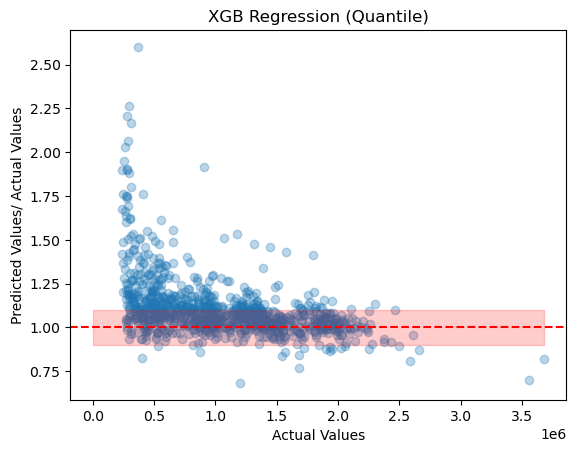

In [185]:
# Graph the data like before
plt.scatter(x= y_val, y= xgb_cv.predict(X_val)/y_val, alpha=0.3)
plt.gca().add_patch(plt.Rectangle((0.9, 0.9), y_val.max(), 0.2, fill=True, color= 'red', alpha=0.2))
plt.axhline(1, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values/ Actual Values')
plt.title('XGB Regression (Quantile)')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

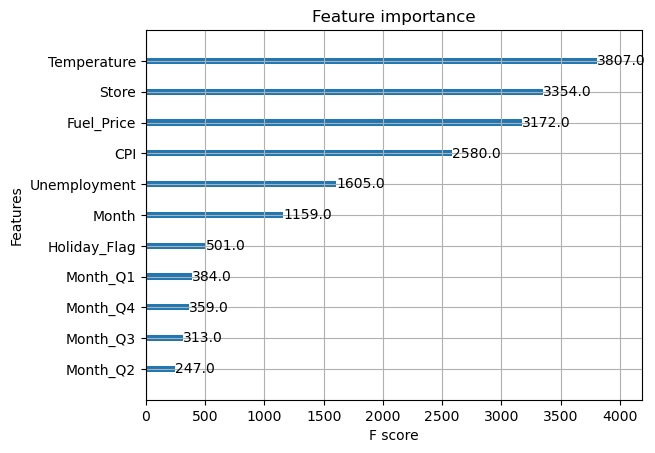

In [186]:
plot_importance(xgb_cv.best_estimator_, importance_type='weight')

 ##### **Step 2.5: Analyze/ Construct Summary**
 - Observations:
     - The XGBoost model built with GridSearchCV which targeted the lowest squared error between predictions and actual values was the highest scoring model tested.
     - The 3 highest contribuiting metrics to the prediction of weekly sales was Temperature, Store, and Fuel_Price. 

 - Next Steps:
     - A wider range of parameters should be screened to increase model performance. This will require sugnificant training time.
___

 ##### **Step 3: Construct**
 At this stage in the process, it is relatively clear which model is the best performing. However, we can certainly still improve it with a little bit of brute force. A better model can also be obtained through further refinement of the dataset, but given the fidelity of the model any further refinement will be accepted and moved forward with.
 The primary goals of the pure construct step is to:
 - generate the final model using a wider array of parameters to better optimize its performance.
 - assess the final model's performance with the 'validate' and 'test' datasets.
 - generate a visual which summarizes the performance of the model in Tableau. 

In [187]:
# Use the data to set up a gradient boosting regressor model
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    # device='cuda'
)

cv_params = {
    # 'device': ['cuda'],
    'n_estimators': list(range(250, 600, 50)),
    'max_depth': list(range(3, 11, 1)),
    'learning_rate': list(np.linspace(0.01, 0.2, 10)),
    'min_child_weight': list(range(1, 6, 1)),
}

xgb_cv = GridSearchCV(xgb, cv_params, cv=5, refit=True)

In [188]:
%%time
if os.path.exists('models/finalized_model.pkl'):
    xgb_cv = pickle.load(open('models/finalized_model.pkl', 'rb'))
    print('Model loaded from disk')
else:
    xgb_cv.fit(X_train, y_train)
    # Save the model to disk
    pickle.dump(xgb_cv, open('models/finalized_model.pkl', 'wb'))


Model loaded from disk
CPU times: total: 31.2 ms
Wall time: 23.5 ms


In [189]:
xgb_cv.best_params_

{'device': 'cuda',
 'learning_rate': 0.1366666666666667,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 500}

In [190]:
tmp = generate_results('XGB_MSE_1', xgb_cv)
results = pd.concat([results, tmp], axis=0)
results

,Model,Mean Squared Error,R-Squared
0,Linear Regression,2.643942e+11,0.145893
0,XGB_MSE_0,7.129052e+09,0.976970
0,RF_MSE_0,7.129052e+09,0.976970
0,XGB_QUANT_0,1.868202e+10,0.939649
0,XGB_MSE_1,6.789789e+09,0.978066


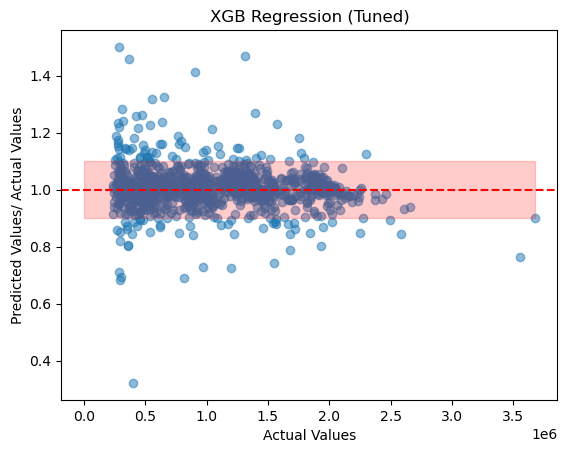

In [191]:
# Graph the data like before
plt.scatter(x= y_val, y= xgb_cv.predict(X_val)/y_val, alpha=0.5)
plt.gca().add_patch(plt.Rectangle((0.9, 0.9), y_val.max(), 0.2, fill=True, color= 'red', alpha=0.2))
plt.axhline(1, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values/ Actual Values')
plt.title('XGB Regression (Tuned)')
plt.show()

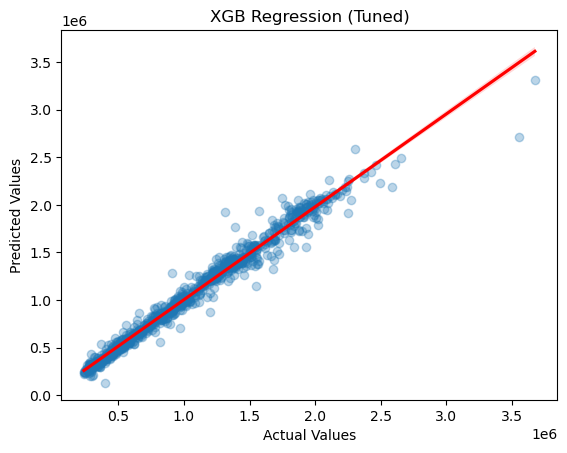

In [192]:
sns.regplot(x=y_val, y=xgb_cv.predict(X_val), line_kws={'color':'red'}, scatter_kws={'color':'#1f77b4','alpha':0.3})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGB Regression (Tuned)')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

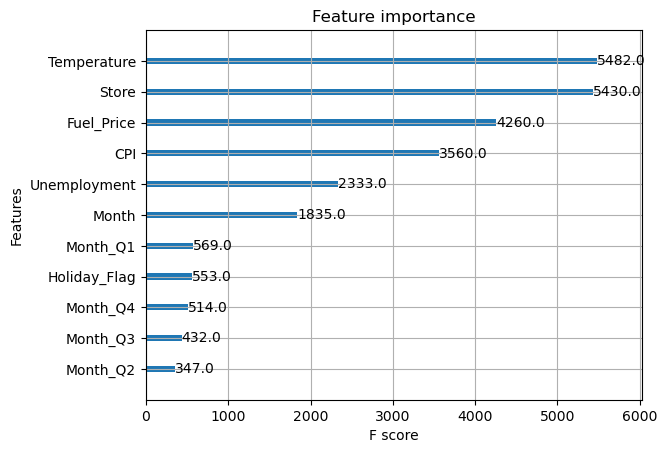

In [193]:
plot_importance(xgb_cv.best_estimator_, importance_type='weight')

In [194]:
final_model_test_results = generate_results('XGB_MSE_1', xgb_cv)
final_model_test_results

,Model,Mean Squared Error,R-Squared
0,XGB_MSE_1,6.789789e+09,0.978066


<Axes: xlabel='Weekly_Sales'>

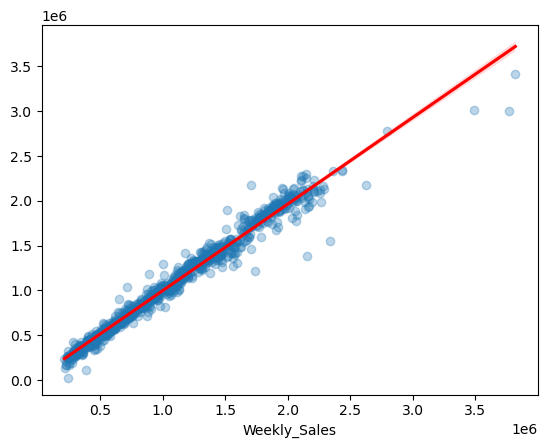

In [195]:
sns.regplot(x=y_test, y=xgb_cv.predict(X_test), line_kws={'color':'red'}, scatter_kws={'color':'#1f77b4','alpha':0.3})

In [196]:
full_y_pred = xgb_cv.predict(X)
time_series = pd.DataFrame({'Date': df['Date'], 'Weekly_Sales': df['Weekly_Sales'], 'Predicted_Weekly_Sales': full_y_pred})
time_series.head()

,Date,Weekly_Sales,Predicted_Weekly_Sales
0,2010-02-05,1643690.90,1645274.875
1,2010-02-12,1641957.44,1645164.000
2,2010-02-19,1611968.17,1609539.875
3,2010-02-26,1409727.59,1410089.250
4,2010-03-05,1554806.68,1557958.000


In [197]:
time_series.to_csv('walmart_prediction_series.csv', index=False)

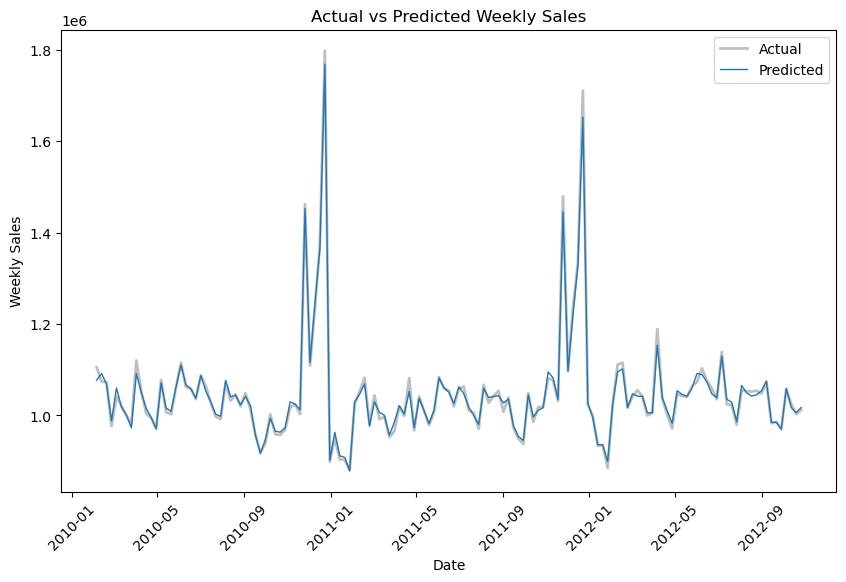

In [198]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=time_series, x='Date', y='Weekly_Sales', color='gray', alpha = 0.5, ci=None, linewidth=2.0)
sns.lineplot(data=time_series, x='Date', y='Predicted_Weekly_Sales', color='#1f77b4', alpha = 1, ci=None, linewidth=1.0)
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(['Actual', 'Predicted'])
plt.xticks(rotation=45)
plt.show()


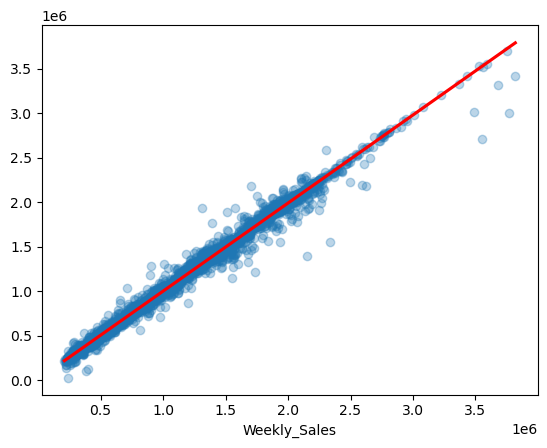

0.9926857311817013

In [199]:
sns.regplot(x=y, y=xgb_cv.predict(X), line_kws={'color':'red'}, scatter_kws={'color':'#1f77b4','alpha':0.3})
plt.show()
final_r2 = r2_score(y, xgb_cv.predict(X))
final_r2

 ##### **Step 3: Construct Summary**
 - Observations:
     - The model improved marginally, but nothing too significant. The quality is sufficient at this point to discuss with any stakeholders. 
     - The visualizations assembled using Tableau will be the point of focus when disclosing the model and results to stakeholders.

 - Next Steps:
     - The final stage of the process is to execute, which is to demonstrate and disclose the findings from the analysis to stakeholders.
___

 ##### **Step 4: Execute**
 In this final stage, the results from the analysis are disclosed to the stakeholders.\
  Due to the nature of this project walking through each and every step, the final data visualization will suffice for demonstrating the key points:\
  - What was learned from the analysis.
  - How the final model performed.
  - How the final model can be used going going forward.
